In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import collections
import math
import random

np.seterr('raise');
EPSILON = 1e-7

In [2]:
def prob_normal_distribution(a, b):
    return 1 / math.sqrt(2 * math.pi * b) * math.exp(-0.5 * a**2 / b)

def prob_triangular_distribution(a, b):
    return max(0, 1 / math.sqrt(6) * b - abs(a) / 6 / b)

# Taken from Kalman Filter book
def normalize_angle(x):
    x = x % (2 * math.pi)
    if x > math.pi:
        x -= 2 * math.pi
        
    return x

# TODO: Test this function
def motion_model_velocity(x_t, u_t, x_, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6):
    '''
    We evaluate the required input to bring x_ to x_t.
    Then, we evaluate the error between the given input the the calculated input.
    Assuming independence of the three movement errors, we compute the probability that we get these errors.
    '''
    x, y, theta = x_
    x_, y_, theta_ = x_t
    v, w = u_t
    
    mu = 0.5 * ((x - x_) * math.cos(theta) + (y - y_) * math.sin(theta)) / ((y - y_) * math.cos(theta) - (x - x_) * math.sin(theta) + EPSILON)
    x_star = (x + x_) / 2 + mu * (y - y_)
    y_star = (y + y_) / 2 + mu * (x - x_)
    r_star = math.sqrt((x - x_star)**2 + (y - y_star)**2)
    delta_theta = math.atan2(y_ - y_star, x_ - x_star) - math.atan2(y - y_star, x - x_star)
    v_ = delta_theta / dt * r_star
    w_ = delta_theta / dt
    gamma = normalize_angle((theta_ - theta) / dt - w_)
    
    return prob(v - v_, a_1 * v**2 + a_2 * w**2) * prob(w - w_, a_3 * v**2 + a_4 * w**2) * prob(gamma, a_5 * v**2 + a_6 * w**2)

def sample_normal_distribution(b):
    return random.gauss(0, b)

def sample_triangular_distribution(b):
    return math.sqrt(6) / 2 * (random.uniform(-b, b) + random.uniform(-b, b))

def sample_motion_model_velocity(u_t, x_, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6):
    '''
    We evaluate one possible final state given an input.
    Calling this function many times will result in different outputs.
    This can be used in conjunction with particle filters.
    '''
    x, y, theta = x_
    v, w = u_t
    
    v_ = v + sample(a_1 * v**2 + a_2 * w**2)
    w_ = w + sample(a_3 * v**2 + a_4 * w**2)
    gamma = sample(a_5 * v**2 + a_6 * w**2)
    x_ = x - v_ / w_ * math.sin(theta) + v_ / w_ * math.sin(theta + w_ * dt)
    y_ = y + v_ / w_ * math.cos(theta) - v_ / w_ * math.cos(theta + w_ * dt)
    theta_ = normalize_angle(theta + w_ * dt + gamma * dt)
    
    return np.array([x_, y_, theta_])

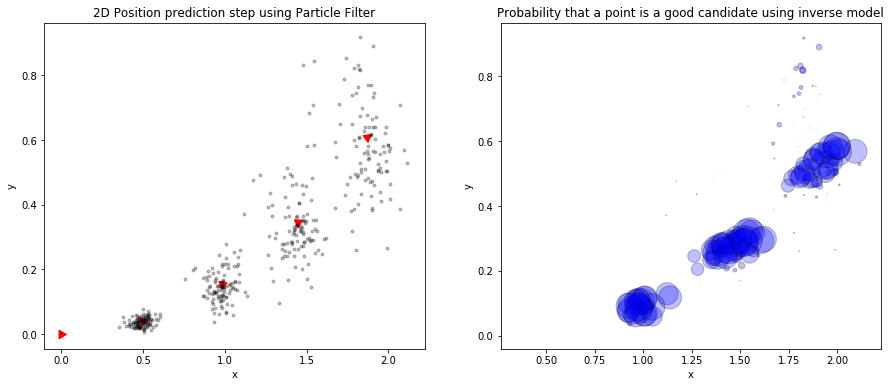

In [5]:
def sample_motion_model_velocity_n(u_t, positions, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6):
    x_s = []
    y_s = []
    theta_s = []
    for position in zip(*positions):
        x, y, theta = sample_motion_model_velocity(u_t, position, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return x_s, y_s, theta_s

def motion_model_velocity_n(positions, u_t, prev_position, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6):
    p_s = np.zeros(len(positions[0]))
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s[i] = motion_model_velocity(position, u_t, prev_position, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6)
        
    return p_s

def simulate_predict_motion_model():
    DT = 0.5
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([1, math.pi / 10])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    a_1, a_2, a_3, a_4, a_5, a_6 = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_velocity_n(u, (x_s, y_s, theta_s), DT, sample, a_1, a_2, a_3, a_4, a_5, a_6)
        p_s = motion_model_velocity_n((x_s, y_s, theta_s), u, perfect_model, DT, prob, a_1, a_2, a_3, a_4, a_5, a_6)
        perfect_model = sample_motion_model_velocity(u, perfect_model, DT, sample, 0, 0, 0, 0, 0, 0)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 500, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_motion_model()

In [19]:
def motion_model_odometry(x_t, u_t, x_, dt, prob, a_1, a_2, a_3, a_4):
    x, y, theta = x_
    x_, y_, theta_ = x_t
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = math.atan2(y_ - y, x_ - x) - theta
    delta_trans_ = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
    delta_rot2_ = theta_ - theta - delta_rot1_
    
    p1 = prob(delta_rot1 - delta_rot1_, a_1 * delta_rot1_**2 + a_2 * delta_trans_**2)
    p2 = prob(delta_trans - delta_trans_, a_3 * delta_trans_**2 + a_4 * (delta_rot1_**2 + delta_rot2_**2))
    p3 = prob(delta_rot2 - delta_rot2_, a_1 * delta_rot2_**2 + a_2 * delta_trans_**2)
    
    return p1 * p2 * p3

def sample_motion_model_odometry(u_t, x_, dt, sample, a_1, a_2, a_3, a_4):
    x, y, theta = x_
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = delta_rot1 - sample(a_1 * delta_rot1 ** 2 + a_2 * delta_trans ** 2)
    delta_trans_ = delta_trans - sample(a_3 * delta_trans ** 2 + a_4 * (delta_rot1 + delta_rot2))
    delta_rot2_ = delta_rot2 - sample(a_1 * delta_rot2 ** 2 + a_1 * delta_trans ** 2)
    
    x_ = x + delta_trans_ * math.cos(theta + delta_rot1)
    y_ = y + delta_trans_ * math.sin(theta + delta_rot2)
    theta_ = theta + delta_rot1_ + delta_rot2_
    
    return x_, y_, theta_

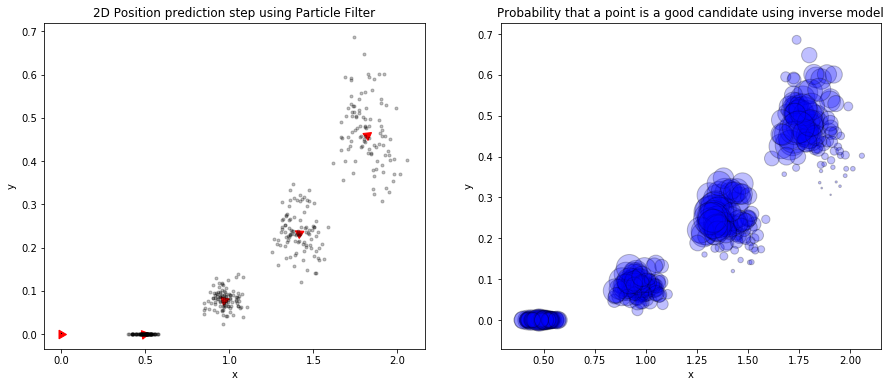

In [27]:
def sample_motion_model_odometry_n(u_t, positions, dt, sample, a_1, a_2, a_3, a_4):
    x_s = []
    y_s = []
    theta_s = []
    for position in zip(*positions):
        x, y, theta = sample_motion_model_odometry(u_t, position, dt, sample, a_1, a_2, a_3, a_4)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return x_s, y_s, theta_s

def motion_model_odometry_n(positions, u_t, prev_position, dt, prob, a_1, a_2, a_3, a_4):
    p_s = np.zeros(len(positions[0]))
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s[i] = motion_model_odometry(position, u_t, prev_position, dt, prob, a_1, a_2, a_3, a_4)
        
    return p_s

def simulate_predict_odometry_model():
    DT = 0.5
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([math.pi / 20, 0.5, 0])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    a_1, a_2, a_3, a_4 = 0.1, 0.1, 0.1, 0.1

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_odometry_n(u, (x_s, y_s, theta_s), DT, sample, a_1, a_2, a_3, a_4)
        p_s = motion_model_odometry_n((x_s, y_s, theta_s), u, perfect_model, DT, prob, a_1, a_2, a_3, a_4)
        perfect_model = sample_motion_model_odometry(u, perfect_model, DT, sample, 0, 0, 0, 0)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 50, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_odometry_model()

In [115]:
%matplotlib inline

def probabilistic_raycast(x_t, m, d, z, z_max, stddev):
    x, y, theta = x_t
    
    dx = math.cos(theta)
    dy = math.sin(theta)
    p = 1
    most_probable = 0
    prev_point = None
    x_, y_ = x, y
    
    # TODO: Add stop condition based 
    while True:
        x_, y_ = x_ + dx *d, y_ + dy * d
        dist = math.sqrt((x_ -x)**2 + (y_ - y)**2)
        i, j = int(round(x_)), int(round(y_))
        
        if i == m.shape[0] or j == m.shape[1] or dist >= z_max:
            break
            
        if prev_point is None or prev_point != (i, j):
            # TODO: Add other sensor model probabilistic phenoms
            try:
                q = p * m[i, j] * scipy.stats.norm(dist, stddev).pdf(z)
            except:
                q = 0
            most_probable = max(most_probable, q)
            p *= 1 - q
            
            #m[i, j] = q
            prev_point = i, j
        
    return most_probable

m = np.array([
    [0.0] * 10
] * 10)
m[2,] = 1
x_t = np.array([5, 5, math.radians(180)])
D = 0.5
Z_MAX = 10
STDDEV = 0.5
z = 3

probabilistic_raycast(x_t, m, D, z, Z_MAX, STDDEV)
#plt.imshow(1 - m, cmap='gray');

0.48394144903828673